In [35]:
!pip install backtrader
!pip install yfinance
!pip install pandas_ta
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import plotly.graph_objects as go
from datetime import datetime, date
import backtrader as bt
import numpy as np
import datetime as dt
from statistics import mean
from statistics import stdev
from collections import OrderedDict
from scipy.stats import skew, kurtosis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM

1. copiar modelo deep learning (lstm) <br>
2. coluna com preços predictions (para s&p e nasdaq) (fomrato pandas)<br>
3. escrever `estrategia`<br>
4. indicadores

--report--<br>

1.tabela com indicadores nasdaq (buy and hold e todos os ma) <br>

In [4]:
#Download S&P500 data from Yahoo Finance
spy = yf.download('SPY', start='1996-01-01', end='2005-12-31', interval='1d') #S&P500 ETF ^IXIC

nasdaq = yf.download('^IXIC', start='1996-01-01', end='2005-12-31', interval='1d') # ^IXIC

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
#add moving averages to our data
spy['log_ajusted_close'] = np.log(spy['Adj Close'])
#spy['MA_1'] = spy['log_ajusted_close'].rolling(window=5).mean()
#spy['MA_2'] = spy['log_ajusted_close'].rolling(window=10).mean()
#spy['MA_4'] = spy['log_ajusted_close'].rolling(window=20).mean()
#spy['MA_10'] = spy['log_ajusted_close'].rolling(window=50).mean()
#spy['MA_20'] = spy['log_ajusted_close'].rolling(window=100).mean()
spy

,Open,High,Low,Close,Adj Close,Volume,log_ajusted_close
Date,,,,,,,
1996-01-02,61.406250,62.140625,61.343750,62.140625,38.113789,514400,3.640576
1996-01-03,62.343750,62.500000,62.000000,62.312500,38.219208,610300,3.643338
1996-01-04,62.390625,62.625000,61.218750,61.718750,37.855038,1129700,3.633764
1996-01-05,61.312500,61.750000,61.171875,61.593750,37.778370,302400,3.631737
1996-01-08,61.812500,61.906250,61.734375,61.828125,37.922123,179900,3.635535
...,...,...,...,...,...,...,...
2005-12-23,126.779999,126.860001,126.419998,126.760002,90.349037,27977300,4.503680
2005-12-27,126.959999,127.050003,125.379997,125.470001,89.429573,44499500,4.493451
2005-12-28,125.739998,125.989998,125.500000,125.750000,89.629120,30764300,4.495680


<Axes: xlabel='Date'>

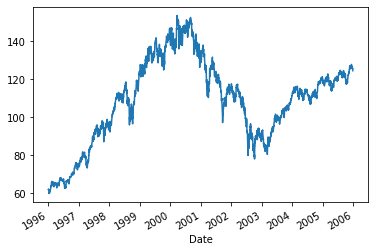

In [6]:
#Plot S&P500 ETF close price 
spy.Close.plot()

In [7]:
#Create a function in backtrater library for buy and hold strategy
class BuyAndHold(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.data)
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [8]:
#initialize backtrater
cerebro = bt.Cerebro()
cerebro.broker.setcash(10000)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue(): ,.2f}')

#Run the model
spy_bt = bt.feeds.PandasData(dataname=spy)
cerebro.adddata(spy_bt)
cerebro.addstrategy(BuyAndHold)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days,
                    data=spy_bt)


results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()


print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
print('mean return: ', mean(results[0].analyzers.annualreturn.get_analysis().values()))
print('stdev: ', stdev(results[0].analyzers.annualreturn.get_analysis().values()))
print('MDD: ', results[0].analyzers.drawdown.get_analysis()['drawdown'])

tret_analyzer = results[0].analyzers.getbyname('timereturn')
daily_list = list(tret_analyzer.get_analysis().values())

print('Min: ',min(tret_analyzer.get_analysis().values()))
print('Max: ',max(tret_analyzer.get_analysis().values()))
print('Kurtosis: ',kurtosis(daily_list))
print('Skewness: ',skew(daily_list))

Starting Portfolio Value:  10,000.00
ROI:        99.47%
Final Portfolio Value: 19,946.60
Sharpe Ratio:  0.4307468376438956
mean return:  0.08724933074949259
stdev:  0.1890389834148409
MDD:  18.89977498761181
Min:  -0.07247340425531912
Max:  0.05966234464710407
Kurtosis:  2.9650421506546616
Skewness:  -0.010600625850939344


In [9]:
class MA1_Strategy(bt.Strategy):

        
    def __init__(self):
        #indicator to use in strategy
        self.ma = bt.indicators.EMA(period=5)
        self.val_start = self.broker.get_cash()
        
        
    def next(self):
        #implement the trading logic
        if self.ma>self.data.close:# not in the market
            self.buy()
                  
        #close open orders
        else:
            if self.ma < self.data.close:  # in the market & cross to the downside
                    self.close()
            

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

        
        
cerebro = bt.Cerebro()
cerebro.broker.setcash(1)
#rename columns name because of indicator
spy_bt = bt.feeds.PandasData(dataname=spy)
cerebro.adddata(spy_bt)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addstrategy(MA1_Strategy)


cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days,
                    data=spy_bt)


results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()


print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
print('mean return: ', mean(results[0].analyzers.annualreturn.get_analysis().values()))
print('stdev: ', stdev(results[0].analyzers.annualreturn.get_analysis().values()))
print('MDD: ', results[0].analyzers.drawdown.get_analysis()['drawdown'])

tret_analyzer = results[0].analyzers.getbyname('timereturn')
daily_list = list(tret_analyzer.get_analysis().values())

print('Min: ',min(tret_analyzer.get_analysis().values()))
print('Max: ',max(tret_analyzer.get_analysis().values()))
print('Kurtosis: ',kurtosis(daily_list))
print('Skewness: ',skew(daily_list))

Starting Value: 1.00
Ending   Value: 2.62
ROI:        162.24%
Final Portfolio Value: 2.62
Sharpe Ratio:  1.0498494909976073
mean return:  0.10492493167187843
stdev:  0.09530857943384798
MDD:  1.2013686724900365
Min:  -0.07247340425531912
Max:  0.05966234464710407
Kurtosis:  2.9650421506546616
Skewness:  -0.010600625850939344


In [10]:
class MA2_Strategy(bt.Strategy):

        
    def __init__(self):
        #indicator to use in strategy
        self.ma = bt.indicators.EMA(period=10)
        self.val_start = self.broker.get_cash()
        
        
    def next(self):
        #implement the trading logic
        if self.ma>self.data.close:# not in the market
            self.buy()
                  
        #close open orders
        else:
            if self.ma < self.data.close:  # in the market & cross to the downside
                    self.close()
            

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

        
        
cerebro = bt.Cerebro()
cerebro.broker.setcash(1)
#rename columns name because of indicator
spy_bt = bt.feeds.PandasData(dataname=spy)
cerebro.adddata(spy_bt)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addstrategy(MA2_Strategy)


cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days,
                    data=spy_bt)


results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()


print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
print('mean return: ', mean(results[0].analyzers.annualreturn.get_analysis().values()))
print('stdev: ', stdev(results[0].analyzers.annualreturn.get_analysis().values()))
print('MDD: ', results[0].analyzers.drawdown.get_analysis()['drawdown'])

tret_analyzer = results[0].analyzers.getbyname('timereturn')
daily_list = list(tret_analyzer.get_analysis().values())

print('Min: ',min(tret_analyzer.get_analysis().values()))
print('Max: ',max(tret_analyzer.get_analysis().values()))
print('Kurtosis: ',kurtosis(daily_list))
print('Skewness: ',skew(daily_list))

Starting Value: 1.00
Ending   Value: 2.00
ROI:        99.81%
Final Portfolio Value: 2.00
Sharpe Ratio:  0.6797973820747644
mean return:  0.07625466466386063
stdev:  0.10273435951804002
MDD:  8.572285497461255
Min:  -0.07247340425531912
Max:  0.05966234464710407
Kurtosis:  2.9650421506546616
Skewness:  -0.010600625850939344


In [11]:
class MA4_Strategy(bt.Strategy):

        
    def __init__(self):
        #indicator to use in strategy
        self.ma = bt.indicators.EMA(period=20)
        self.val_start = self.broker.get_cash()
        
        
    def next(self):
        #implement the trading logic
        if self.ma>self.data.close:# not in the market
            self.buy()
                  
        #close open orders
        else:
            if self.ma < self.data.close:  # in the market & cross to the downside
                    self.close()
            

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

        
        
cerebro = bt.Cerebro()
cerebro.broker.setcash(1)
#rename columns name because of indicator
spy_bt = bt.feeds.PandasData(dataname=spy)
cerebro.adddata(spy_bt)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addstrategy(MA4_Strategy)


cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days,
                    data=spy_bt)


results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()


print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
print('mean return: ', mean(results[0].analyzers.annualreturn.get_analysis().values()))
print('stdev: ', stdev(results[0].analyzers.annualreturn.get_analysis().values()))
print('MDD: ', results[0].analyzers.drawdown.get_analysis()['drawdown'])

tret_analyzer = results[0].analyzers.getbyname('timereturn')
daily_list = list(tret_analyzer.get_analysis().values())

print('Min: ',min(tret_analyzer.get_analysis().values()))
print('Max: ',max(tret_analyzer.get_analysis().values()))
print('Kurtosis: ',kurtosis(daily_list))
print('Skewness: ',skew(daily_list))

Starting Value: 1.00
Ending   Value: 1.79
ROI:        79.38%
Final Portfolio Value: 1.79
Sharpe Ratio:  0.5338933187414544
mean return:  0.06593946065371056
stdev:  0.11044410343005964
MDD:  15.41324666033511
Min:  -0.07247340425531912
Max:  0.05966234464710407
Kurtosis:  2.9650421506546616
Skewness:  -0.010600625850939344


In [12]:
class MA10_Strategy(bt.Strategy):

        
    def __init__(self):
        #indicator to use in strategy
        self.ma = bt.indicators.EMA(period=50)
        self.val_start = self.broker.get_cash()
        
        
    def next(self):
        #implement the trading logic
        if self.ma>self.data.close:# not in the market
            self.buy()
                  
        #close open orders
        else:
            if self.ma < self.data.close:  # in the market & cross to the downside
                    self.close()
            

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

        
        
cerebro = bt.Cerebro()
cerebro.broker.setcash(1)
#rename columns name because of indicator
spy_bt = bt.feeds.PandasData(dataname=spy)
cerebro.adddata(spy_bt)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addstrategy(MA10_Strategy)


cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days,
                    data=spy_bt)


results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()


print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
print('mean return: ', mean(results[0].analyzers.annualreturn.get_analysis().values()))
print('stdev: ', stdev(results[0].analyzers.annualreturn.get_analysis().values()))
print('MDD: ', results[0].analyzers.drawdown.get_analysis()['drawdown'])

tret_analyzer = results[0].analyzers.getbyname('timereturn')
daily_list = list(tret_analyzer.get_analysis().values())

print('Min: ',min(tret_analyzer.get_analysis().values()))
print('Max: ',max(tret_analyzer.get_analysis().values()))
print('Kurtosis: ',kurtosis(daily_list))
print('Skewness: ',skew(daily_list))

Starting Value: 1.00
Ending   Value: 1.44
ROI:        44.17%
Final Portfolio Value: 1.44
Sharpe Ratio:  0.31314958374019114
mean return:  0.04285610672215989
stdev:  0.11059691351188945
MDD:  22.223346687759033
Min:  -0.07247340425531912
Max:  0.05966234464710407
Kurtosis:  2.9650421506546616
Skewness:  -0.010600625850939344


In [13]:
class MA20_Strategy(bt.Strategy):

        
    def __init__(self):
        #indicator to use in strategy
        self.ma = bt.indicators.EMA(period=100)
        self.val_start = self.broker.get_cash()
        
        
    def next(self):
        #implement the trading logic
        if self.ma>self.data.close:# not in the market
            self.buy()
                  
        #close open orders
        else:
            if self.ma < self.data.close:  # in the market & cross to the downside
                    self.close()
            

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

        
        
cerebro = bt.Cerebro()
cerebro.broker.setcash(1)
#rename columns name because of indicator
spy_bt = bt.feeds.PandasData(dataname=spy)
cerebro.adddata(spy_bt)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addstrategy(MA20_Strategy)


cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days,
                    data=spy_bt)


results = cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()


print(f'Final Portfolio Value: {cerebro.broker.getvalue():,.2f}')
print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
print('mean return: ', mean(results[0].analyzers.annualreturn.get_analysis().values()))
print('stdev: ', stdev(results[0].analyzers.annualreturn.get_analysis().values()))
print('MDD: ', results[0].analyzers.drawdown.get_analysis()['drawdown'])

tret_analyzer = results[0].analyzers.getbyname('timereturn')
daily_list = list(tret_analyzer.get_analysis().values())

print('Min: ',min(tret_analyzer.get_analysis().values()))
print('Max: ',max(tret_analyzer.get_analysis().values()))
print('Kurtosis: ',kurtosis(daily_list))
print('Skewness: ',skew(daily_list))

Starting Value: 1.00
Ending   Value: 1.56
ROI:        56.18%
Final Portfolio Value: 1.56
Sharpe Ratio:  0.4657601434392612
mean return:  0.0491045443474606
stdev:  0.08850007794993196
MDD:  13.181006269460017
Min:  -0.07247340425531912
Max:  0.05966234464710407
Kurtosis:  2.9650421506546616
Skewness:  -0.010600625850939344


### Implement a Data Science strategy

In [14]:
# Set random seed for numpy:
np.random.seed(42)

# Set random seed for tensorFlow
tf.random.set_seed(24)

In [15]:
#Verify the type of our date column
type(spy.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [19]:
#create a copy of spy dataframe with only close price
closed_spy = spy.Close.copy()

#remove date from index to change to a datetime type variable
closed_spy = closed_spy.reset_index()
closed_spy['Date'] = pd.to_datetime(closed_spy['Date'])
closed_spy.set_index("Date", inplace=True)

#Verify the shape of data (we need 2D array)
closed_spy.shape

(2519, 1)

In [24]:
#create a copy of nasdaq dataframe with only close price
closed_nasdaq = nasdaq.Close.copy()

#remove date from index to change to a datetime type variable
closed_nasdaq = closed_nasdaq.reset_index()
closed_nasdaq['Date'] = pd.to_datetime(closed_nasdaq['Date'])
closed_nasdaq.set_index("Date", inplace=True)

#Verify the shape of data (we need 2D array)
closed_nasdaq.shape

(2519, 1)

In [25]:
#Split SPY data into train, validation and test

split_time_spy = int(len(spy.Close)*0.25)   # split 25% of our data

train_spy = closed_spy[:-split_time_spy]
test_spy = closed_spy[-split_time_spy:]

# Remove last 25% of the training dataset for validation:
val_spy = train_spy[-split_time_spy:]
train_spy = train_spy[:-split_time_spy]

print(f"Shape of train data: {train_spy.shape}")
print(f"Shape of val data: {val_spy.shape}")
print(f"Shape of test data: {test_spy.shape}")

Shape of train data: (1261, 1)
Shape of val data: (629, 1)
Shape of test data: (629, 1)


In [26]:
#Split Nasdaq data into train, validation and test

split_time_nasdaq = int(len(nasdaq.Close)*0.25)   # split 25% of our data

train_nasdaq = closed_nasdaq[:-split_time_nasdaq]
test_nasdaq = closed_nasdaq[-split_time_nasdaq:]

# Remove last 25% of the training dataset for validation:
val_nasdaq = train_nasdaq[-split_time_nasdaq:]
train_nasdaq = train_nasdaq[:-split_time_nasdaq]

print(f"Shape of train data: {train_nasdaq.shape}")
print(f"Shape of val data: {val_nasdaq.shape}")
print(f"Shape of test data: {test_nasdaq.shape}")

Shape of train data: (1261, 1)
Shape of val data: (629, 1)
Shape of test data: (629, 1)


In [31]:
#reshape spy data with MinMaxScaler()
spy_scaler = MinMaxScaler()

#spy data
train_spy = spy_scaler.fit_transform(train_spy)
val_spy = spy_scaler.transform(val_spy)
test_spy = spy_scaler.transform(test_spy)

print(f"Shape of train: {train_spy.shape}")
print(f"Shape of val: {val_spy.shape}")
print(f"Shape of test: {test_spy.shape}")

Shape of train: (1261, 1)
Shape of val: (629, 1)
Shape of test: (629, 1)


In [32]:
#reshape nasdaq data with MinMaxScaler()
nasdaq_scaler = MinMaxScaler()

# data
train_nasdaq = nasdaq_scaler.fit_transform(train_nasdaq)
val_nasdaq = nasdaq_scaler.transform(val_nasdaq)
test_nasdaq = nasdaq_scaler.transform(test_nasdaq)

print(f"Shape of train: {train_nasdaq.shape}")
print(f"Shape of val: {val_nasdaq.shape}")
print(f"Shape of test: {test_nasdaq.shape}")

Shape of train: (1261, 1)
Shape of val: (629, 1)
Shape of test: (629, 1)


In [34]:
#Prepare data for training the model in spy dataset

timesteps = 30  # number of time steps to look back
batch_size = 32  # number of samples per batch

train_generator = TimeseriesGenerator(train_spy, train_spy, length=timesteps, batch_size=batch_size)
val_generator = TimeseriesGenerator(val_spy, val_spy, length=timesteps, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_spy, test_spy, length=timesteps, batch_size=batch_size)

# Shared attributes:
loss_function = 'mse'  
optimizer = 'adam'  
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train_spy.shape

In [36]:
# Define LSTM's architecture here:

lstm_model = Sequential()
lstm_model.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model.add(Dense(1))
lstm_model.add(Dense(1))

lstm_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
 dense_1 (Dense)             (None, 1, 1)              2         
                                                                 
Total params: 66,691
Trainable params: 66,691
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_lstm_model = lstm_model.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

lstm_model.save('lstm_model.h5')

Epoch 1/50
39/39 [==============================] - 5s 56ms/step - loss: 0.0882 - mae: 0.2117 - val_loss: 0.0210 - val_mae: 0.0982
Epoch 2/50
39/39 [==============================] - 2s 39ms/step - loss: 0.0297 - mae: 0.1104 - val_loss: 0.0162 - val_mae: 0.0850
Epoch 3/50
39/39 [==============================] - 1s 37ms/step - loss: 0.0205 - mae: 0.0802 - val_loss: 0.0118 - val_mae: 0.0687
Epoch 4/50
39/39 [==============================] - 1s 38ms/step - loss: 0.0169 - mae: 0.0739 - val_loss: 0.0110 - val_mae: 0.0713
Epoch 5/50
39/39 [==============================] - 1s 38ms/step - loss: 0.0139 - mae: 0.0657 - val_loss: 0.0087 - val_mae: 0.0618
Epoch 6/50
39/39 [==============================] - 2s 38ms/step - loss: 0.0121 - mae: 0.0648 - val_loss: 0.0081 - val_mae: 0.0608
Epoch 7/50
39/39 [==============================] - 1s 37ms/step - loss: 0.0105 - mae: 0.0602 - val_loss: 0.0098 - val_mae: 0.0739
Epoch 8/50
39/39 [==============================] - 1s 37ms/step - loss: 0.0101 - m

<ipython-input-37-6dcc6fe1791a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model = lstm_model.fit_generator(


In [38]:
def evaluate_model(model, model_name, train_gen, val_gen, test_gen, verbose=False):
    """Utility function that prints loss and MAE scores of a given model. Returns the results in a dataframe."""
    if verbose:
        print(f"Evaluation of {model_name}:")
    
    train_loss, train_mae = model.evaluate_generator(train_gen)
    val_loss, val_mae = model.evaluate_generator(val_gen)
    test_loss, test_mae = model.evaluate_generator(test_gen)
    
    if verbose:
        print(f"\nTest loss: {round(test_loss, 4)} \t | \ttest mae: {round(test_mae, 4)}")
        print(f"Val loss: {round(val_loss, 4)} \t | \tval mae: {round(val_mae, 4)}")
        print(f"Train loss: {round(train_loss, 4)} \t | \ttrain mae: {round(train_mae, 4)}")
        
    return pd.DataFrame.from_dict(
        [
            {
                "model_name": model_name,
                "test_loss": round(test_loss, 4),
                "test_mae": round(test_mae, 4),
                "val_loss": round(val_loss, 4),
                "val_mae": round(val_mae, 4),
                "train_loss": round(train_loss, 4),
                "train_mae": round(train_mae, 4)
            }
        ]
    )

In [39]:
results_lstm = evaluate_model(
    lstm_model,
    "LSTM_MODEL",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm

Evaluation of LSTM_MODEL_3:

Test loss: 0.0008 	 | 	test mae: 0.0217
Val loss: 0.004 	 | 	val mae: 0.047
Train loss: 0.0024 	 | 	train mae: 0.0362


<ipython-input-38-72f2a30c971e>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
<ipython-input-38-72f2a30c971e>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
<ipython-input-38-72f2a30c971e>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL_3,0.0008,0.0217,0.004,0.047,0.0024,0.0362


In [47]:
# Assuming you have a test_generator for generating test data
predictions = lstm_model.predict(test_generator)

print(predictions)

19/19 [==============================] - 0s 16ms/step
[[[0.4860876 ]
  [0.45344347]
  [0.4442329 ]
  ...
  [0.4266942 ]
  [0.42725956]
  [0.43016964]]

 [[0.48952073]
  [0.45049143]
  [0.43370548]
  ...
  [0.4273063 ]
  [0.43020812]
  [0.43728456]]

 [[0.48517287]
  [0.43977717]
  [0.43646476]
  ...
  [0.43025512]
  [0.43732306]
  [0.4426099 ]]

 ...

 [[0.66686815]
  [0.6742397 ]
  [0.6762268 ]
  ...
  [0.7069324 ]
  [0.70887184]
  [0.699258  ]]

 [[0.6632327 ]
  [0.6752188 ]
  [0.6854548 ]
  ...
  [0.7089056 ]
  [0.69928616]
  [0.69854206]]

 [[0.6652519 ]
  [0.6847268 ]
  [0.69185275]
  ...
  [0.6993201 ]
  [0.6985703 ]
  [0.6950957 ]]]


In [99]:
# Define the range of your desired stock price
min_price = min(closed_spy.Close)
max_price = max(closed_spy.Close)

# Rescale the predicted values to the desired stock price range
rescaled_values = (predictions * (max_price - min_price)) + min_price

# Round the rescaled values to a certain number of decimal places
rounded_values = np.round(rescaled_values, 2)

print(rounded_values.shape)

(599, 30, 1)


In [55]:
df = yf.download('^IXIC', start='2006-01-01', end='2006-12-31', interval='1d') # ^IXIC

#create a copy of spy dataframe with only closed price
df_close = df.Close.copy()

#remove date from index to change to a datetime type variable
df_close = df_close.reset_index()
df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index("Date", inplace=True)


scaler = MinMaxScaler()
df_test = scaler.fit_transform(df_close)
        
test_generator2 = TimeseriesGenerator(df_test, df_test, length=timesteps, batch_size=batch_size)


real_predictions = lstm_model.predict(test_generator2)
print(real_predictions)

[*********************100%***********************]  1 of 1 completed
7/7 [==============================] - 0s 14ms/step
[[[0.5336434 ]
  [0.5419807 ]
  [0.5697494 ]
  ...
  [0.54434687]
  [0.51412797]
  [0.5353478 ]]

 [[0.56596154]
  [0.57331413]
  [0.6233594 ]
  ...
  [0.51416653]
  [0.5353796 ]
  [0.5694164 ]]

 [[0.5881381 ]
  [0.626127  ]
  [0.6597687 ]
  ...
  [0.53541887]
  [0.5694482 ]
  [0.6052828 ]]

 ...

 [[0.80952114]
  [0.89206403]
  [0.9220598 ]
  ...
  [0.8723207 ]
  [0.8445426 ]
  [0.85925955]]

 [[0.8522488 ]
  [0.9218867 ]
  [0.93756133]
  ...
  [0.84456944]
  [0.85928184]
  [0.8929077 ]]

 [[0.87364197]
  [0.9370955 ]
  [0.9346016 ]
  ...
  [0.8593093 ]
  [0.89293   ]
  [0.88889134]]]


In [64]:
# Define the range of your desired stock price
min_price = min(df_close.Close)
max_price = max(df_close.Close)

# Rescale the predicted values to the desired stock price range = (real_predictions * (max_price - min_price)) + min_price

# Round the rescaled values to a certain number of decimal places
rounded_values = np.round(rescaled_values, 2)

In [73]:
#plot closed price vs predictions
pandas = pd.DataFrame(rounded_values)
df.Close.plot()
pandas.plot()

ValueError: ValueError: Must pass 2-d input. shape=(221, 30, 1)

In [96]:
rounded_values2 = rounded_values.tolist()
for c in rounded_values2:
    print(c)


[[2258.179931640625], [2261.889892578125], [2274.260009765625], [2302.080078125], [2317.39990234375], [2320.889892578125], [2329.080078125], [2321.219970703125], [2318.18994140625], [2308.489990234375], [2289.35009765625], [2299.02001953125], [2267.169921875], [2254.409912109375], [2265.25], [2265.679931640625], [2279.409912109375], [2299.489990234375], [2305.93994140625], [2305.72998046875], [2308.93994140625], [2290.010009765625], [2270.580078125], [2263.510009765625], [2252.93994140625], [2263.989990234375], [2261.7099609375], [2262.949951171875], [2249.47998046875], [2258.93994140625]]
[[2272.580078125], [2275.85009765625], [2298.14990234375], [2318.199951171875], [2321.169921875], [2329.110107421875], [2321.3798828125], [2318.39990234375], [2308.77001953125], [2289.669921875], [2299.320068359375], [2267.4599609375], [2254.679931640625], [2265.47998046875], [2265.8701171875], [2279.570068359375], [2299.6201171875], [2306.050048828125], [2305.820068359375], [2309.010009765625], [229

In [101]:
import csv

# Save the Python list to a CSV file
with open('data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rounded_values2)

In [105]:
rounded_values.shape

(599, 30, 1)

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1996-01-02  1052.829956  1058.880005  1048.469971  1058.650024  1058.650024   
1996-01-03  1056.359985  1058.920044  1045.319946  1046.260010  1046.260010   
1996-01-04  1047.199951  1047.640015  1021.570007  1029.819946  1029.819946   
1996-01-05  1022.409973  1033.469971  1017.690002  1033.469971  1033.469971   
1996-01-08  1034.939941  1035.619995  1031.339966  1032.369995  1032.369995   
...                 ...          ...          ...          ...          ...   
2005-12-23  2249.409912  2254.709961  2245.580078  2249.419922  2249.419922   
2005-12-27  2253.050049  2259.679932  2226.620117  2226.889893  2226.889893   
2005-12-28  2230.360107  2233.540039  2221.409912  2228.939941  2228.939941   
2005-12-29  2229.600098  2232.889893  2216.979980  2218.159912

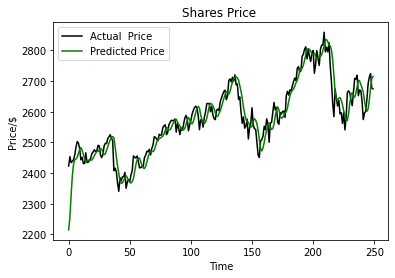

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# LOAD DATA
data = yf.download('^IXIC', start='1996-01-01', end='2005-12-31', interval='1d') # ^IXIC
print(data)

#PREPARE DATE
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

predictions_days = 60

X_train = []
y_train = []

for x in range(predictions_days, len(scaled_data)):
    X_train.append(scaled_data[x-predictions_days:x, 0])
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#BUILD THE MODEL
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # PREDICTION OF THE NEXT CLOSE CANDLE

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

#TEST THE MODEL ACCURACY ON EXISTING DATA

#LOAD THE DATA
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download('^IXIC', start='2006-01-01', end='2006-12-31', interval='1d') # ^IXIC
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - predictions_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# MAKE PREDICTIONS ON TEST DATA
X_test = []

for x in range(predictions_days, len(model_inputs)):
    X_test.append(model_inputs[x-predictions_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

#PLOT  THE TEST PREDICTIONS
plt.plot(actual_prices, color='black', label=f'Actual  Price')
plt.plot(predicted_prices, color='green', label=f'Predicted Price')
plt.title(f'Shares Price ')
plt.xlabel('Time')
plt.ylabel('Price/$')
plt.legend()
plt.show()

# PREDICT NEXT DAY
real_data = [model_inputs[len(model_inputs) + 1 - predictions_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

predictions = model.predict(real_data)
predictions = scaler.inverse_transform(predictions)
print(f'Prediction: {predictions}')

In [116]:
predicted_prices[::2]

array([[2214.7646],
 [2327.4028],
 [2429.1992],
 [2446.0005],
 [2464.2844],
 [2483.478 ],
 [2461.6985],
 [2436.4805],
 [2441.8787],
 [2441.7761],
 [2448.5833],
 [2464.6238],
 [2471.1802],
 [2480.184 ],
 [2467.865 ],
 [2462.755 ],
 [2486.0437],
 [2508.4998],
 [2519.03 ],
 [2486.7747],
 [2423.4055],
 [2374.2358],
 [2367.8835],
 [2383.371 ],
 [2385.032 ],
 [2370.0051],
 [2372.2246],
 [2405.6187],
 [2442.8223],
 [2447.8884],
 [2424.25 ],
 [2414.6538],
 [2436.7043],
 [2463.6394],
 [2470.2168],
 [2474.385 ],
 [2501.121 ],
 [2511.5452],
 [2517.3137],
 [2528.1106],
 [2548.6855],
 [2541.1875],
 [2548.0896],
 [2567.3823],
 [2575.3582],
 [2559.3418],
 [2544.596 ],
 [2540.6975],
 [2557.8804],
 [2581.1636],
 [2563.8982],
 [2567.944 ],
 [2598.7468],
 [2617.3533],
 [2590.061 ],
 [2566.773 ],
 [2566.2139],
 [2598.6829],
 [2627.788 ],
 [2619.4626],
 [2595.831 ],
 [2585.4587],
 [2603.4546],
 [2629.7288],
 [2656.1855],
 [2662.775 ],
 [2665.3552],
 [2696.3784],
 [2710.6323],
 [2709.8816],
 [2684.947 ],
 [2644.0156],
 [2594.0583],
 [2565.7573],
 [2557.0737],
 [2551.2178],
 [2577.3535],
 [2560.8428],
 [2508.6494],
 [2472.1863],
 [2500.2598],
 [2540.1492],
 [2563.1655],
 [2542.5422],
 [2560.021 ],
 [2605.8047],
 [2606.6565],
 [2579.1797],
 [2588.5952],
 [2599.2751],
 [2633.7937],
 [2663.5022],
 [2675.093 ],
 [2694.6987],
 [2716.0435],
 [2739.538 ],
 [2751.8254],
 [2786.7007],
 [2803.8767],
 [2798.1252],
 [2785.6594],
 [2781.1362],
 [2773.6155],
 [2779.541 ],
 [2800.1816],
 [2833.5972],
 [2828.2192],
 [2814.4927],
 [2768.6763],
 [2663.1228],
 [2641.2046],
 [2646.177 ],
 [2623.4756],
 [2591.1748],
 [2571.2297],
 [2628.007 ],
 [2662.306 ],
 [2647.0798],
 [2681.8708],
 [2700.534 ],
 [2677.6426],
 [2635.422 ],
 [2601.4019],
 [2639.2578],
 [2708.5647]], dtype=float32)